In [1]:
import math, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd

## Use CUDA

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cpu


## Configuración del entorno

In [3]:
env_id = "CartPole-v1"
env = gym.make(env_id)
print(f"Espacio de observación: {env.observation_space.shape}")
print(f"Espacio de acción: {env.action_space.n}")

Espacio de observación: (4,)
Espacio de acción: 2


## Configuración de epsilon-greedy

In [4]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 1000

In [5]:
def epsilon_by_episode(episode):
    return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)


## Agentes

### Agente Base

In [6]:
class BaseAgent:
    def __init__(self, state_dim, action_dim, name="BaseAgent"):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.name = name
        self.episodes_data = []  # Para almacenar episodios completos

    def select_action(self, state, epsilon):
        """Selección de acción epsilon-greedy"""
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        else:
            return self.get_best_action(state)

    def get_best_action(self, state):
        """Debe ser implementado por cada agente"""
        raise NotImplementedError

    def train(self, episodes_data):
        """Debe ser implementado por cada agente"""
        raise NotImplementedError

    def generate_episode(self, env, epsilon, max_steps=500):
        """Genera un episodio completo"""
        episode = []
        state, _ = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = self.select_action(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode.append((state.copy(), action, reward, next_state.copy(), done))
            state = next_state
            total_reward += reward

            if done:
                break

        return episode, total_reward

### Agente Monte Carlo

In [7]:
class MonteCarloAgent(BaseAgent):
    def __init__(self, state_dim, action_dim):
        super().__init__(state_dim, action_dim, "MonteCarlo")
        self.q_values = defaultdict(lambda: defaultdict(float))
        self.visit_counts = defaultdict(lambda: defaultdict(int))
        self.state_discretizer = StateDiscretizer(state_dim)

    def get_best_action(self, state):
        discrete_state = self.state_discretizer.discretize(state)
        if discrete_state not in self.q_values:
            return random.randrange(self.action_dim)

        q_vals = [self.q_values[discrete_state][a] for a in range(self.action_dim)]
        return np.argmax(q_vals)

    def train(self, episodes_data):
        """Entrenamiento Monte Carlo con primeras visitas"""
        for episode in episodes_data:
            # Calcular retornos
            returns = self.calculate_returns(episode)

            # Actualizar Q-values con primeras visitas
            visited = set()
            for i, (state, action, _, _, _) in enumerate(episode):
                discrete_state = self.state_discretizer.discretize(state)
                state_action = (discrete_state, action)

                if state_action not in visited:
                    visited.add(state_action)
                    self.visit_counts[discrete_state][action] += 1

                    # Promedio incremental
                    old_q = self.q_values[discrete_state][action]
                    count = self.visit_counts[discrete_state][action]
                    self.q_values[discrete_state][action] = old_q + (returns[i] - old_q) / count

    def calculate_returns(self, episode, gamma=0.99):
        """Calcula retornos descontados para cada paso"""
        returns = []
        G = 0
        for i in reversed(range(len(episode))):
            _, _, reward, _, _ = episode[i]
            G = reward + gamma * G
            returns.append(G)
        return list(reversed(returns))

### Discretizador de Estados

In [8]:
class StateDiscretizer:
    def __init__(self, state_dim, bins_per_dim=10):
        self.state_dim = state_dim
        self.bins_per_dim = bins_per_dim
        # Rangos típicos para CartPole-v1
        self.ranges = [
            (-4.8, 4.8),      # posición del carrito
            (-4.0, 4.0),      # velocidad del carrito
            (-0.418, 0.418),  # ángulo del poste
            (-4.0, 4.0)       # velocidad angular del poste
        ]

    def discretize(self, state):
        discrete_state = []
        for i, value in enumerate(state):
            min_val, max_val = self.ranges[i]
            bin_idx = int((value - min_val) / (max_val - min_val) * self.bins_per_dim)
            bin_idx = max(0, min(bin_idx, self.bins_per_dim - 1))
            discrete_state.append(bin_idx)
        return tuple(discrete_state)

### Agente con Árbol de Decisión

In [9]:
class DecisionTreeAgent(BaseAgent):
    def __init__(self, state_dim, action_dim):
        super().__init__(state_dim, action_dim, "DecisionTree")
        self.models = [DecisionTreeRegressor(max_depth=10, random_state=42)
                      for _ in range(action_dim)]
        self.scaler = StandardScaler()
        self.is_trained = False

    def get_best_action(self, state):
        if not self.is_trained:
            return random.randrange(self.action_dim)

        state_scaled = self.scaler.transform([state])
        q_values = [model.predict(state_scaled)[0] for model in self.models]
        return np.argmax(q_values)

    def train(self, episodes_data):
        # Preparar datos de entrenamiento
        X, y = self.prepare_training_data(episodes_data)

        if len(X) == 0:
            return

        # Escalar características
        X_scaled = self.scaler.fit_transform(X)

        # Entrenar un modelo por acción
        for action in range(self.action_dim):
            action_mask = (np.array([sample[1] for sample in y]) == action)
            if np.sum(action_mask) > 0:
                X_action = X_scaled[action_mask]
                y_action = np.array([sample[0] for sample in y])[action_mask]
                self.models[action].fit(X_action, y_action)

        self.is_trained = True

    def prepare_training_data(self, episodes_data, gamma=0.99):
        X, y = [], []

        for episode in episodes_data:
            returns = self.calculate_returns(episode, gamma)
            for i, (state, action, _, _, _) in enumerate(episode):
                X.append(state)
                y.append((returns[i], action))

        return np.array(X), y

    def calculate_returns(self, episode, gamma=0.99):
        returns = []
        G = 0
        for i in reversed(range(len(episode))):
            _, _, reward, _, _ = episode[i]
            G = reward + gamma * G
            returns.append(G)
        return list(reversed(returns))

### Agente con Random Forest

In [10]:
class RandomForestAgent(BaseAgent):
    def __init__(self, state_dim, action_dim):
        super().__init__(state_dim, action_dim, "RandomForest")
        self.models = [RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
                      for _ in range(action_dim)]
        self.scaler = StandardScaler()
        self.is_trained = False

    def get_best_action(self, state):
        if not self.is_trained:
            return random.randrange(self.action_dim)

        state_scaled = self.scaler.transform([state])
        q_values = [model.predict(state_scaled)[0] for model in self.models]
        return np.argmax(q_values)

    def train(self, episodes_data):
        # Preparar datos de entrenamiento
        X, y = self.prepare_training_data(episodes_data)

        if len(X) == 0:
            return

        # Escalar características
        X_scaled = self.scaler.fit_transform(X)

        # Entrenar un modelo por acción
        for action in range(self.action_dim):
            action_mask = (np.array([sample[1] for sample in y]) == action)
            if np.sum(action_mask) > 0:
                X_action = X_scaled[action_mask]
                y_action = np.array([sample[0] for sample in y])[action_mask]
                self.models[action].fit(X_action, y_action)

        self.is_trained = True

    def prepare_training_data(self, episodes_data, gamma=0.99):
        X, y = [], []

        for episode in episodes_data:
            returns = self.calculate_returns(episode, gamma)
            for i, (state, action, _, _, _) in enumerate(episode):
                X.append(state)
                y.append((returns[i], action))

        return np.array(X), y

    def calculate_returns(self, episode, gamma=0.99):
        returns = []
        G = 0
        for i in reversed(range(len(episode))):
            _, _, reward, _, _ = episode[i]
            G = reward + gamma * G
            returns.append(G)
        return list(reversed(returns))

### Agente con Red Neuronal

In [11]:
class NeuralNetworkAgent(BaseAgent):
    def __init__(self, state_dim, action_dim):
        super().__init__(state_dim, action_dim, "NeuralNetwork")
        self.model = self.build_network(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.scaler = StandardScaler()
        self.is_trained = False

    def build_network(self, state_dim, action_dim):
        return nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def get_best_action(self, state):
        if not self.is_trained:
            return random.randrange(self.action_dim)

        self.model.eval()
        with torch.no_grad():
            state_scaled = self.scaler.transform([state])
            state_tensor = torch.FloatTensor(state_scaled).to(device)
            q_values = self.model(state_tensor)
            return q_values.argmax().cpu().item()

    def train(self, episodes_data, epochs=50):
        # Preparar datos
        X, y, actions = self.prepare_training_data(episodes_data)

        if len(X) == 0:
            return

        # Escalar características
        X_scaled = self.scaler.fit_transform(X)

        # Convertir a tensores
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        y_tensor = torch.FloatTensor(y).to(device)
        actions_tensor = torch.LongTensor(actions).to(device)

        # Entrenamiento
        self.model.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()

            # Forward pass
            q_values = self.model(X_tensor)
            predicted_q = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze()

            # Loss y backward pass
            loss = F.mse_loss(predicted_q, y_tensor)
            loss.backward()
            self.optimizer.step()

            if epoch % 10 == 0:
                print(f"Época {epoch}, Loss: {loss.item():.4f}")

        self.is_trained = True

    def prepare_training_data(self, episodes_data, gamma=0.99):
        X, y, actions = [], [], []

        for episode in episodes_data:
            returns = self.calculate_returns(episode, gamma)
            for i, (state, action, _, _, _) in enumerate(episode):
                X.append(state)
                y.append(returns[i])
                actions.append(action)

        return np.array(X), np.array(y), np.array(actions)

    def calculate_returns(self, episode, gamma=0.99):
        returns = []
        G = 0
        for i in reversed(range(len(episode))):
            _, _, reward, _, _ = episode[i]
            G = reward + gamma * G
            returns.append(G)
        return list(reversed(returns))

## Funciones de Entrenamiento y Evaluación

In [12]:
def train_agent(agent, env, num_episodes=1000, train_frequency=50):
    """Entrena un agente usando Monte Carlo"""
    rewards_history = []
    success_rate_history = []
    episodes_buffer = []

    print(f"\n=== Entrenando {agent.name} ===")

    for episode in range(num_episodes):
        epsilon = epsilon_by_episode(episode)

        # Generar episodio
        episode_data, total_reward = agent.generate_episode(env, epsilon)
        episodes_buffer.append(episode_data)
        rewards_history.append(total_reward)

        # Entrenar periódicamente
        if (episode + 1) % train_frequency == 0 and len(episodes_buffer) > 0:
            agent.train(episodes_buffer)
            episodes_buffer = []  # Limpiar buffer después de entrenar

        # Mostrar progreso
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            success_rate = np.mean([1 if r >= 500 else 0 for r in rewards_history[-100:]])
            success_rate_history.append(success_rate)
            print(f"Episodio {episode + 1}, Reward promedio: {avg_reward:.2f}, "
                  f"Tasa de éxito: {success_rate:.2%}, Epsilon: {epsilon:.3f}")

    return rewards_history, success_rate_history

In [13]:
def evaluate_agent(agent, env, num_episodes=100):
    """Evalúa un agente entrenado"""
    rewards = []
    success_count = 0

    for episode in range(num_episodes):
        episode_data, total_reward = agent.generate_episode(env, epsilon=0.0)  # Sin exploración
        rewards.append(total_reward)
        if total_reward >= 500:
            success_count += 1

    avg_reward = np.mean(rewards)
    success_rate = success_count / num_episodes

    print(f"\n=== Evaluación {agent.name} ===")
    print(f"Reward promedio: {avg_reward:.2f} ± {np.std(rewards):.2f}")
    print(f"Tasa de éxito: {success_rate:.2%} ({success_count}/{num_episodes})")

    return avg_reward, success_rate, rewards

In [14]:
def plot_training_results(agents_results):
    """Visualiza los resultados de entrenamiento"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Rewards durante entrenamiento
    for agent_name, (rewards, success_rates) in agents_results.items():
        # Suavizar con ventana móvil
        window_size = 50
        smoothed_rewards = pd.Series(rewards).rolling(window_size, min_periods=1).mean()
        ax1.plot(smoothed_rewards, label=agent_name, alpha=0.8)

    ax1.set_xlabel('Episodios')
    ax1.set_ylabel('Reward Promedio')
    ax1.set_title('Curvas de Aprendizaje (Suavizadas)')
    ax1.legend()
    ax1.grid(True)

    # Tasa de éxito durante entrenamiento
    for agent_name, (rewards, success_rates) in agents_results.items():
        episodes = range(100, len(success_rates) * 100 + 1, 100)
        ax2.plot(episodes, success_rates, label=agent_name, marker='o')

    ax2.set_xlabel('Episodios')
    ax2.set_ylabel('Tasa de Éxito')
    ax2.set_title('Tasa de Éxito Durante Entrenamiento')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim([0, 1])

    # Histograma de rewards finales
    colors = ['blue', 'orange', 'green', 'red']
    for i, (agent_name, (rewards, _)) in enumerate(agents_results.items()):
        final_rewards = rewards[-100:]  # Últimos 100 episodios
        ax3.hist(final_rewards, alpha=0.6, bins=20, label=agent_name, color=colors[i % len(colors)])

    ax3.set_xlabel('Reward')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de Rewards (Últimos 100 Episodios)')
    ax3.legend()
    ax3.grid(True)

    # Comparación de métricas finales
    agent_names = list(agents_results.keys())
    avg_rewards = [np.mean(results[0][-100:]) for results in agents_results.values()]
    final_success_rates = [results[1][-1] if results[1] else 0 for results in agents_results.values()]

    x_pos = np.arange(len(agent_names))
    ax4_twin = ax4.twinx()

    bars1 = ax4.bar(x_pos - 0.2, avg_rewards, 0.4, label='Reward Promedio', color='skyblue')
    bars2 = ax4_twin.bar(x_pos + 0.2, final_success_rates, 0.4, label='Tasa de Éxito', color='lightcoral')

    ax4.set_xlabel('Agentes')
    ax4.set_ylabel('Reward Promedio', color='skyblue')
    ax4_twin.set_ylabel('Tasa de Éxito', color='lightcoral')
    ax4.set_title('Comparación Final de Agentes')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(agent_names, rotation=45)
    ax4.grid(True)

    # Añadir valores en las barras
    for bar, value in zip(bars1, avg_rewards):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{value:.1f}', ha='center', va='bottom')

    for bar, value in zip(bars2, final_success_rates):
        ax4_twin.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{value:.2%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## Experimento

In [15]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [16]:
agents = {
        'Monte Carlo': MonteCarloAgent(state_dim, action_dim),
        'Árbol de Decisión': DecisionTreeAgent(state_dim, action_dim),
        'Random Forest': RandomForestAgent(state_dim, action_dim),
        'Red Neuronal': NeuralNetworkAgent(state_dim, action_dim)
    }

In [17]:
agents_results = {}
training_episodes = 1500

In [18]:
for name, agent in agents.items():
    rewards_history, success_rate_history = train_agent(agent, env, training_episodes)
    agents_results[name] = (rewards_history, success_rate_history)


=== Entrenando MonteCarlo ===
Episodio 100, Reward promedio: 23.93, Tasa de éxito: 0.00%, Epsilon: 0.907
Episodio 200, Reward promedio: 27.77, Tasa de éxito: 0.00%, Epsilon: 0.821
Episodio 300, Reward promedio: 37.58, Tasa de éxito: 0.00%, Epsilon: 0.744
Episodio 400, Reward promedio: 51.56, Tasa de éxito: 0.00%, Epsilon: 0.674
Episodio 500, Reward promedio: 60.20, Tasa de éxito: 0.00%, Epsilon: 0.611
Episodio 600, Reward promedio: 72.57, Tasa de éxito: 0.00%, Epsilon: 0.554
Episodio 700, Reward promedio: 110.83, Tasa de éxito: 0.00%, Epsilon: 0.502
Episodio 800, Reward promedio: 117.45, Tasa de éxito: 0.00%, Epsilon: 0.455
Episodio 900, Reward promedio: 134.71, Tasa de éxito: 0.00%, Epsilon: 0.413
Episodio 1000, Reward promedio: 153.54, Tasa de éxito: 0.00%, Epsilon: 0.375
Episodio 1100, Reward promedio: 168.64, Tasa de éxito: 0.00%, Epsilon: 0.340
Episodio 1200, Reward promedio: 169.44, Tasa de éxito: 0.00%, Epsilon: 0.308
Episodio 1300, Reward promedio: 177.62, Tasa de éxito: 0.00%

In [19]:
evaluation_results = {}
for name, agent in agents.items():
    avg_reward, success_rate, rewards = evaluate_agent(agent, env, 100)
    evaluation_results[name] = {
        'avg_reward': avg_reward,
        'success_rate': success_rate,
        'std_reward': np.std(rewards)
    }


=== Evaluación MonteCarlo ===
Reward promedio: 229.60 ± 76.32
Tasa de éxito: 3.00% (3/100)

=== Evaluación DecisionTree ===
Reward promedio: 54.35 ± 53.27
Tasa de éxito: 0.00% (0/100)

=== Evaluación RandomForest ===
Reward promedio: 19.16 ± 9.04
Tasa de éxito: 0.00% (0/100)

=== Evaluación NeuralNetwork ===
Reward promedio: 500.00 ± 0.00
Tasa de éxito: 100.00% (100/100)


In [20]:
results_df = pd.DataFrame(evaluation_results).T
results_df = results_df.round(4)
print(results_df)

                   avg_reward  success_rate  std_reward
Monte Carlo            229.60          0.03     76.3193
Árbol de Decisión       54.35          0.00     53.2681
Random Forest           19.16          0.00      9.0429
Red Neuronal           500.00          1.00      0.0000


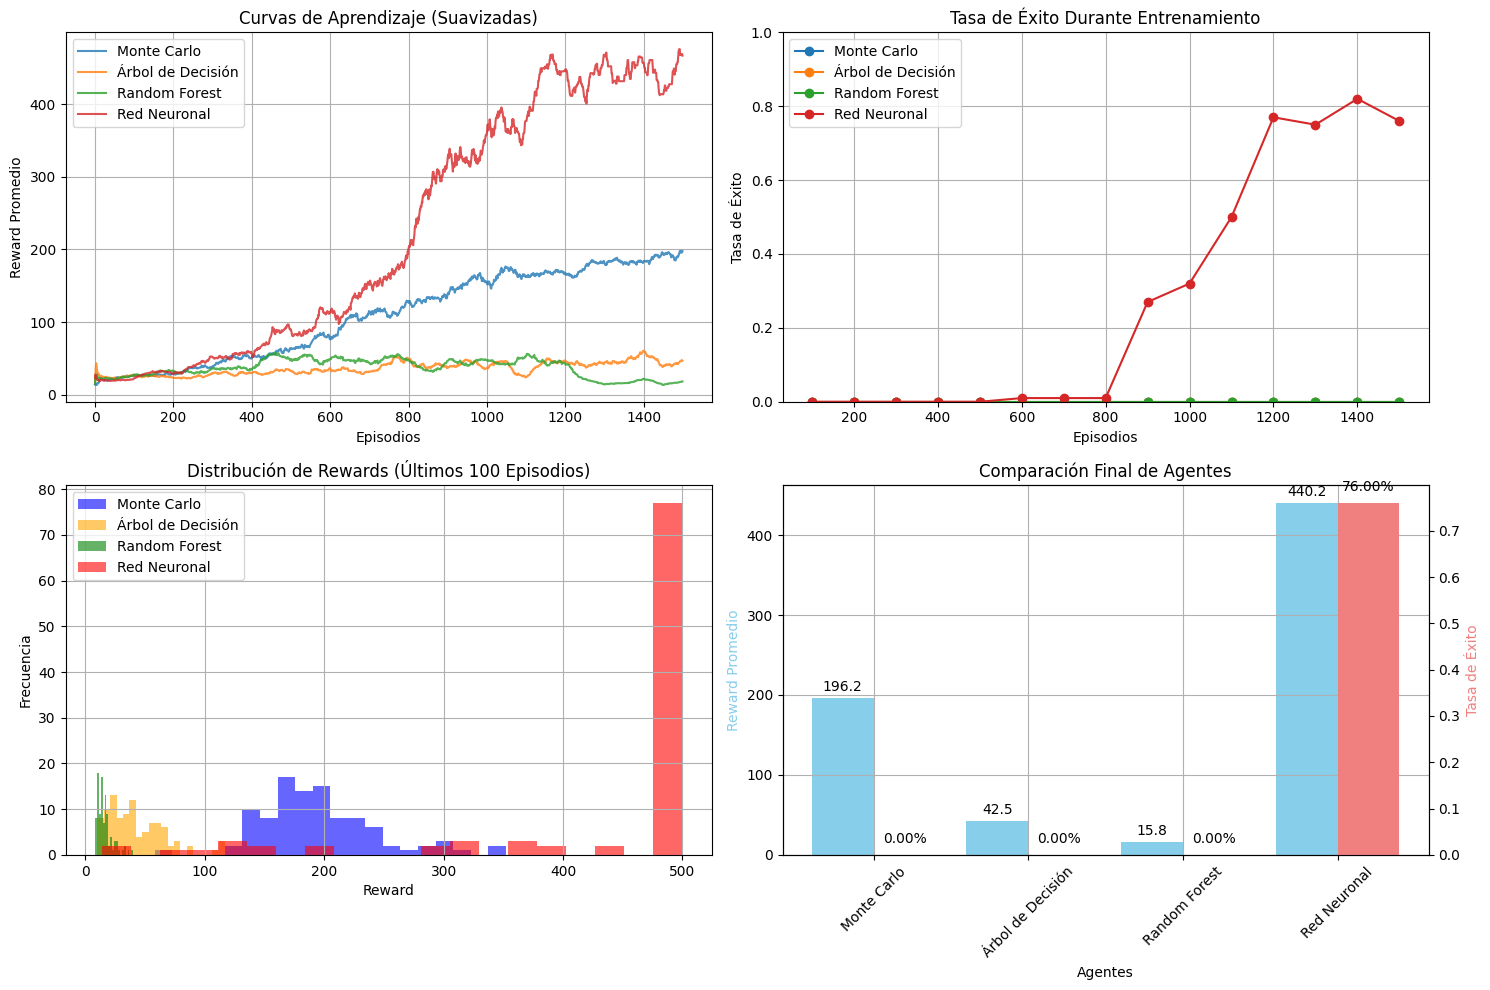

In [21]:
plot_training_results(agents_results)

In [22]:
best_agent_name = max(evaluation_results.keys(),
                     key=lambda x: evaluation_results[x]['avg_reward'])
best_results = evaluation_results[best_agent_name]

In [23]:
print(f"\n🏆 MEJOR AGENTE: {best_agent_name}")
print(f"   • Reward promedio: {best_results['avg_reward']:.2f} ± {best_results['std_reward']:.2f}")
print(f"   • Tasa de éxito: {best_results['success_rate']:.2%}")


🏆 MEJOR AGENTE: Red Neuronal
   • Reward promedio: 500.00 ± 0.00
   • Tasa de éxito: 100.00%
